# Finetuning Lag-LLama on our data

## Imports

In [1]:
!pip install torch lightning gluonts pandas numpy matplotlib seaborn scikit-learn jupyter ipywidgets transformers datasets accelerate optuna


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%cd lag-llama
%pip install -r requirements.txt --quiet
%cd ..


/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lag-llama



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis


In [3]:
from itertools import islice

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from torch.serialization import add_safe_globals
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions.studentT import StudentTOutput
add_safe_globals([NegativeLogLikelihood, StudentTOutput])


/tmp/ipykernel_12038/3158499648.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Read in Data

In [4]:
# Read in data
years = ["2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("data/2019_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data["Date"] = all_data["ISO Time"].dt.date
all_data["Hour"] = all_data["ISO Time"].dt.hour
hourly_avg = all_data.groupby(["Date", "Hour"]).mean()
hourly_avg

Data Collected


ISO Time  Temperature (C)  Humidity (%)  \
Date       Hour                                                                
2019-01-01 0    2019-01-01 00:29:31.316666624         4.293500    100.000000   
           1    2019-01-01 01:29:31.300000000         4.125000    100.000000   
           2    2019-01-01 02:29:31.300000000         4.056333    100.000000   
           3    2019-01-01 03:29:31.333333248         3.946500    100.000000   
           4    2019-01-01 04:29:31.349999872         3.739667    100.000000   
...                                       ...              ...           ...   
2024-12-31 19   2024-12-31 19:29:31.783333120         3.260667     87.923000   
           20   2024-12-31 20:27:45.234042624         3.269362     86.244255   
           21   2024-12-31 21:30:40.961538560         3.188462     86.157500   
           22   2024-12-31 22:30:33.415094272         3.008491     85.458868   
           23   2024-12-31 23:29:45.310344704         2.883103     85.040517   

                 Pressure (kPa)  Air Quality (Ohms)  
Date       Hour                                      
2019-01-01 0          97.444250        3.253975e+04  
           1          97.446067        3.273012e+04  
           2          97.384150        3.299228e+04  
           3          97.308767        3.124677e+04  
           4          97.258917        3.359688e+04  
...                         ...                 ...  
2024-12-31 19        101.286583        1.069465e+06  
           20        101.242021        1.062867e+06  
           21        101.193154        1.044766e+06  
           22        101.163792        1.117850e+06  
           23        101.073000        1.031384e+06  

[51931 rows x 5 columns]

In [5]:
data = hourly_avg["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
data = data.reset_index()
data['datetime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
data = data.set_index('datetime')
data.drop(columns=["Date", "Hour"], inplace=True)
data

,Temperature (C)
datetime,
2019-01-01 00:00:00,4.293500
2019-01-01 01:00:00,4.125000
2019-01-01 02:00:00,4.056333
2019-01-01 03:00:00,3.946500
2019-01-01 04:00:00,3.739667
...,...
2024-12-31 19:00:00,3.260667
2024-12-31 20:00:00,3.269362
2024-12-31 21:00:00,3.188462


In [6]:
# Check if all timestamps are exactly one hour apart
time_diffs = data.index.to_series().diff().value_counts()
print("Time differences between consecutive timestamps (in hours):")
print(time_diffs)

# Check for any missing hours
expected_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
missing_hours = expected_range.difference(data.index)
print(f"\nNumber of missing hours: {len(missing_hours)}")
if len(missing_hours) > 0:
    print("First 10 missing timestamps:")
    print(missing_hours[:10])
    
# Fill missing timestamps with NA values
complete_data = data.reindex(expected_range)
print(f"\nData shape before filling: {data.shape}")
print(f"Data shape after filling: {complete_data.shape}")
print(f"Number of NaN values: {complete_data.isna().sum()[0]}")

# Replace the original data with the complete data
data = complete_data
data["Temperature (C)"] = data["Temperature (C)"].astype(np.float32)

Time differences between consecutive timestamps (in hours):
datetime
0 days 01:00:00     51926
0 days 02:00:00         2
0 days 05:00:00         1
28 days 00:00:00        1
Name: count, dtype: int64

Number of missing hours: 677
First 10 missing timestamps:
DatetimeIndex(['2021-04-23 14:00:00', '2021-04-23 15:00:00',
               '2021-04-23 16:00:00', '2021-04-23 17:00:00',
               '2022-11-19 10:00:00', '2022-11-19 11:00:00',
               '2022-11-19 12:00:00', '2022-11-19 13:00:00',
               '2022-11-19 14:00:00', '2022-11-19 15:00:00'],
              dtype='datetime64[ns]', freq=None)

Data shape before filling: (51931, 1)
Data shape after filling: (52608, 1)
Number of NaN values: 677


/tmp/ipykernel_12038/1210952327.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Number of NaN values: {complete_data.isna().sum()[0]}")


<Figure size 1400x500 with 0 Axes>

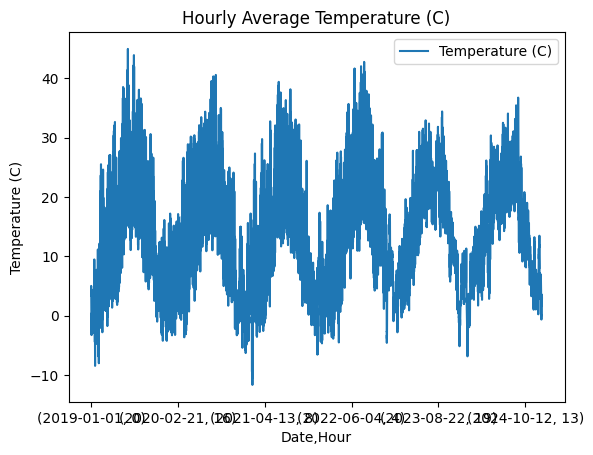

In [7]:
plt.figure(figsize=(14, 5))
hourly_avg.plot(y="Temperature (C)")
plt.title(f"Hourly Average Temperature (C)")
plt.ylabel("Temperature (C)")
plt.show()

### Test data

Time differences between consecutive timestamps (in hours):
datetime
0 days 01:00:00    3924
Name: count, dtype: int64

Number of missing hours: 0

Data shape before filling: (3925, 1)
Data shape after filling: (3925, 1)
Number of NaN values: 0


/tmp/ipykernel_12038/2853238354.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Number of NaN values: {complete_data.isna().sum()[0]}")


<Figure size 1400x500 with 0 Axes>

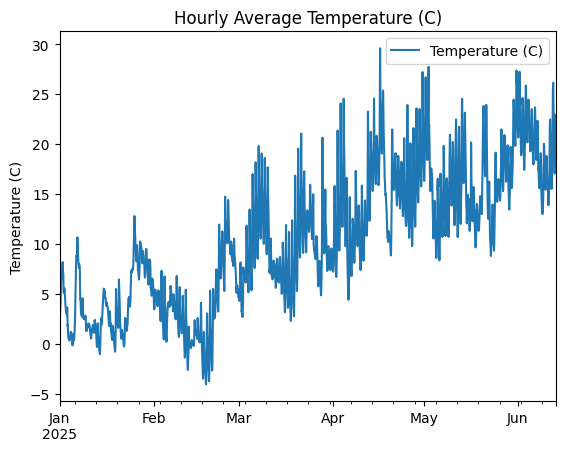

In [8]:
test_data = pd.read_csv("data/2025_BME680SensorData.csv", usecols=columns)
test_data["ISO Time"] = pd.to_datetime(test_data["ISO Time"])
test_data["Date"] = test_data["ISO Time"].dt.date
test_data["Hour"] = test_data["ISO Time"].dt.hour
hourly_avg_test = test_data.groupby(["Date", "Hour"]).mean()
hourly_avg_test

test_data = hourly_avg_test["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
test_data = test_data.reset_index()
test_data['datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Hour'], unit='h')
test_data = test_data.set_index('datetime')
test_data.drop(columns=["Date", "Hour"], inplace=True)
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)



# Check if all timestamps are exactly one hour apart
time_diffs = test_data.index.to_series().diff().value_counts()
print("Time differences between consecutive timestamps (in hours):")
print(time_diffs)

# Check for any missing hours
expected_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max(), freq='H')
missing_hours = expected_range.difference(test_data.index)
print(f"\nNumber of missing hours: {len(missing_hours)}")
if len(missing_hours) > 0:
    print("First 10 missing timestamps:")
    print(missing_hours[:10])
    
# Fill missing timestamps with NA values
complete_data = test_data.reindex(expected_range)
print(f"\nData shape before filling: {test_data.shape}")
print(f"Data shape after filling: {complete_data.shape}")
print(f"Number of NaN values: {complete_data.isna().sum()[0]}")

# Replace the original data with the complete data
test_data = complete_data
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)


# Plot the data
plt.figure(figsize=(14, 5))
test_data.plot(y="Temperature (C)")
plt.title(f"Hourly Average Temperature (C)")
plt.ylabel("Temperature (C)")
plt.show()

In [9]:
# Convert data to GluonTS format
train_ds = PandasDataset(
    data,
    target="Temperature (C)",
    freq="H"  # Hourly data,

)

test_ds = PandasDataset(
    test_data,
    target="Temperature (C)",
    freq="H"  # Hourly data
)


## Model Setup

In [10]:
prediction_length = 24  # Predict one day ahead
context_length = prediction_length * 7 # One week context 
num_samples = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
patience = 5 # Patience for early stopping


In [11]:

ckpt_path = "lag-llama/lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)


In [12]:
# Set up the estimator
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Create the estimator with fine-tuning configuration
estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],
    nonnegative_pred_samples=True,
    aug_prob=0.5,
    lr=1e-4,
    batch_size=batch_size,
    num_parallel_samples=num_samples,
    trainer_kwargs={"max_epochs": 30},
    dropout=0.1  # Add some dropout for regularization
)


## Hyperparameter Optimization with Optuna and Cross-Validation


[I 2025-07-04 18:21:32,562] A new study created in memory with name: lag_llama_cv



Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.00942 (best 1.00942), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.91794 (best 0.91794), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.87363 (best 0.87363), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.84926 (best 0.84926), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.83346 (best 0.83346), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.80245 (best 0.80245), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.79424 (best 0.79424), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.77787 (best 0.77787), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.74666 (best 0.74666), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.71675 (best 0.71675), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_0/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.30s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 1.6620

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.16920 (best 1.16920), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.07762 (best 1.07762), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.05545 (best 1.05545), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.96685 (best 0.96685), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.94795 (best 0.94795), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.93055 (best 0.93055), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.91478 (best 0.91478), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.85730 (best 0.85730), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.85426 (best 0.85426), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 0.78451 (best 0.78451), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.77215 (best 0.77215), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' reached 0.74442 (best 0.74442), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached 0.73371 (best 0.73371), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' reached 0.71088 (best 0.71088), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_1/checkpoints/epoch=28-step=1450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.19s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 1.1072

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.00233 (best 0.00233), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached -0.02921 (best -0.02921), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached -0.14814 (best -0.14814), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.19428 (best -0.19428), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached -0.27727 (best -0.27727), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached -0.31640 (best -0.31640), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached -0.33782 (best -0.33782), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached -0.34795 (best -0.34795), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached -0.35307 (best -0.35307), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' reached -0.40103 (best -0.40103), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' reached -0.41717 (best -0.41717), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=23-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' reached -0.44713 (best -0.44713), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_2/checkpoints/epoch=26-step=1350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.21s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.2954


[I 2025-07-04 18:38:54,236] Trial 0 finished with value: 1.3548731298524428 and parameters: {'lr': 1.329291894316217e-05}. Best is trial 0 with value: 1.3548731298524428.



Trial completed with parameters: lr=1.329291894316217e-05
Average RMSE across 3 folds: 1.3549

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.30972 (best 1.30972), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.14503 (best 1.14503), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.89087 (best 0.89087), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.76956 (best 0.76956), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached 0.73713 (best 0.73713), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_3/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.45s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 2.0295

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 2.72020 (best 2.72020), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.49249 (best 1.49249), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 1.33491 (best 1.33491), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 1.25668 (best 1.25668), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 1.01494 (best 1.01494), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.99515 (best 0.99515), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 0.92557 (best 0.92557), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' reached 0.84880 (best 0.84880), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_4/checkpoints/epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.35s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 2.4006

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.67091 (best 0.67091), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.03545 (best 0.03545), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached -0.01564 (best -0.01564), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.05166 (best -0.05166), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.22210 (best -0.22210), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached -0.26231 (best -0.26231), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' reached -0.26561 (best -0.26561), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_5/checkpoints/epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.21s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 0.4479


[I 2025-07-04 18:56:35,535] Trial 1 finished with value: 1.626005000603888 and parameters: {'lr': 0.0007114476009343421}. Best is trial 0 with value: 1.3548731298524428.



Trial completed with parameters: lr=0.0007114476009343421
Average RMSE across 3 folds: 1.6260

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.83452 (best 0.83452), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.83212 (best 0.83212), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.79813 (best 0.79813), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.74254 (best 0.74254), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.72726 (best 0.72726), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached 0.72403 (best 0.72403), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached 0.69528 (best 0.69528), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_6/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.37s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 3.7616

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.09157 (best 1.09157), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.86154 (best 0.86154), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.83691 (best 0.83691), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_7/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 0.71065 (best 0.71065), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_7/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached 0.65104 (best 0.65104), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_7/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.28s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 0.9539

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.47695 (best 0.47695), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached -0.09155 (best -0.09155), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached -0.10374 (best -0.10374), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached -0.18448 (best -0.18448), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached -0.23308 (best -0.23308), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.27063 (best -0.27063), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached -0.39663 (best -0.39663), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached -0.41502 (best -0.41502), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached -0.42162 (best -0.42162), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached -0.45422 (best -0.45422), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_8/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.46s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.2951


[I 2025-07-04 19:13:42,550] Trial 2 finished with value: 2.003516770121568 and parameters: {'lr': 0.000157029708840554}. Best is trial 0 with value: 1.3548731298524428.



Trial completed with parameters: lr=0.000157029708840554
Average RMSE across 3 folds: 2.0035

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.82064 (best 0.82064), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.78964 (best 0.78964), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.75308 (best 0.75308), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.72656 (best 0.72656), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.72256 (best 0.72256), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.69346 (best 0.69346), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_9/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.29s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 1.4228

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.06737 (best 1.06737), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.98893 (best 0.98893), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.94384 (best 0.94384), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.77294 (best 0.77294), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 0.77292 (best 0.77292), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 0.73865 (best 0.73865), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached 0.72912 (best 0.72912), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 0.65936 (best 0.65936), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_10/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.27s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 1.1788

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached -0.08032 (best -0.08032), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached -0.12469 (best -0.12469), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached -0.14497 (best -0.14497), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached -0.25553 (best -0.25553), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.32334 (best -0.32334), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.35734 (best -0.35734), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached -0.35850 (best -0.35850), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached -0.38234 (best -0.38234), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached -0.39429 (best -0.39429), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached -0.41797 (best -0.41797), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached -0.44293 (best -0.44293), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' reached -0.45732 (best -0.45732), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached -0.46513 (best -0.46513), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached -0.47519 (best -0.47519), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_11/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.38s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.0370


[I 2025-07-04 19:31:03,346] Trial 3 finished with value: 1.2128851882135763 and parameters: {'lr': 6.251373574521755e-05}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=6.251373574521755e-05
Average RMSE across 3 folds: 1.2129

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.09387 (best 1.09387), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.00964 (best 1.00964), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.96203 (best 0.96203), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.92750 (best 0.92750), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.91216 (best 0.91216), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.88092 (best 0.88092), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.87144 (best 0.87144), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.86101 (best 0.86101), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.83536 (best 0.83536), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 0.81841 (best 0.81841), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached 0.78929 (best 0.78929), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached 0.78072 (best 0.78072), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_12/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.38s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 1.6412

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.33644 (best 1.33644), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.21788 (best 1.21788), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.19477 (best 1.19477), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 1.14059 (best 1.14059), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 1.11104 (best 1.11104), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 1.10567 (best 1.10567), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 1.04689 (best 1.04689), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 1.02654 (best 1.02654), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 1.02509 (best 1.02509), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.99473 (best 0.99473), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.98557 (best 0.98557), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached 0.94712 (best 0.94712), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached 0.92493 (best 0.92493), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 0.91091 (best 0.91091), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' reached 0.90315 (best 0.90315), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' reached 0.88772 (best 0.88772), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=23-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached 0.85756 (best 0.85756), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' reached 0.84737 (best 0.84737), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_13/checkpoints/epoch=27-step=1400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.36s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 0.7335

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.27271 (best 0.27271), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.11784 (best 0.11784), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.04173 (best 0.04173), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached -0.02328 (best -0.02328), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.08374 (best -0.08374), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached -0.10759 (best -0.10759), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached -0.11956 (best -0.11956), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached -0.12858 (best -0.12858), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached -0.16065 (best -0.16065), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' reached -0.18248 (best -0.18248), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_14/checkpoints/epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.37s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.9085


[I 2025-07-04 19:48:23,420] Trial 4 finished with value: 1.427728199450569 and parameters: {'lr': 2.9380279387035354e-06}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=2.9380279387035354e-06
Average RMSE across 3 folds: 1.4277

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.10469 (best 1.10469), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.03174 (best 1.03174), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.94565 (best 0.94565), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.94536 (best 0.94536), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.92068 (best 0.92068), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.90213 (best 0.90213), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.89845 (best 0.89845), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.87266 (best 0.87266), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 0.85441 (best 0.85441), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.82318 (best 0.82318), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached 0.81725 (best 0.81725), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 0.80516 (best 0.80516), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' reached 0.80007 (best 0.80007), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' reached 0.77829 (best 0.77829), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_15/checkpoints/epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.30s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 1.8074

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.39413 (best 1.39413), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.23170 (best 1.23170), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.19489 (best 1.19489), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 1.11352 (best 1.11352), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 1.06967 (best 1.06967), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 1.04369 (best 1.04369), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.98619 (best 0.98619), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.98280 (best 0.98280), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached 0.96372 (best 0.96372), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 0.95024 (best 0.95024), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached 0.91521 (best 0.91521), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' reached 0.90430 (best 0.90430), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=21-step=1100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached 0.87273 (best 0.87273), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' reached 0.84632 (best 0.84632), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=26-step=1350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' reached 0.84630 (best 0.84630), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_16/checkpoints/epoch=27-step=1400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.28s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 1.2263

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.28616 (best 0.28616), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.12279 (best 0.12279), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.00654 (best 0.00654), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached -0.01994 (best -0.01994), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached -0.05570 (best -0.05570), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.06299 (best -0.06299), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached -0.08473 (best -0.08473), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached -0.09939 (best -0.09939), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached -0.11987 (best -0.11987), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached -0.13506 (best -0.13506), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached -0.17290 (best -0.17290), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' reached -0.18462 (best -0.18462), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_17/checkpoints/epoch=23-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.46s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 2.0465


[I 2025-07-04 20:05:48,980] Trial 5 finished with value: 1.6934009077916006 and parameters: {'lr': 2.9375384576328313e-06}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=2.9375384576328313e-06
Average RMSE across 3 folds: 1.6934

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.17234 (best 1.17234), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.12074 (best 1.12074), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.01190 (best 1.01190), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.97028 (best 0.97028), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.94491 (best 0.94491), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 0.93550 (best 0.93550), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.93053 (best 0.93053), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.92184 (best 0.92184), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.89575 (best 0.89575), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached 0.88278 (best 0.88278), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached 0.83934 (best 0.83934), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' reached 0.81802 (best 0.81802), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_18/checkpoints/epoch=28-step=1450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.38s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 1.6933

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.45955 (best 1.45955), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.36040 (best 1.36040), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.27790 (best 1.27790), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 1.24305 (best 1.24305), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 1.14428 (best 1.14428), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 1.13125 (best 1.13125), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 1.08301 (best 1.08301), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 1.03863 (best 1.03863), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached 1.00837 (best 1.00837), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' reached 0.97791 (best 0.97791), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' reached 0.97559 (best 0.97559), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=23-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached 0.94349 (best 0.94349), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_19/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.45s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 1.6028

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.40926 (best 0.40926), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.25558 (best 0.25558), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.18522 (best 0.18522), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.09655 (best 0.09655), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.04620 (best 0.04620), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.00975 (best 0.00975), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.00434 (best 0.00434), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.01555 (best -0.01555), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached -0.04016 (best -0.04016), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached -0.06406 (best -0.06406), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' reached -0.06840 (best -0.06840), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=15-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached -0.08744 (best -0.08744), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' reached -0.10028 (best -0.10028), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=21-step=1100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached -0.11922 (best -0.11922), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' reached -0.15077 (best -0.15077), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_20/checkpoints/epoch=29-step=1500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.27s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.9073


[I 2025-07-04 20:23:04,905] Trial 6 finished with value: 1.7344936798620207 and parameters: {'lr': 1.493656855461763e-06}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=1.493656855461763e-06
Average RMSE across 3 folds: 1.7345

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.08329 (best 1.08329), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.08152 (best 1.08152), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.83111 (best 0.83111), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.82432 (best 0.82432), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.75781 (best 0.75781), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached 0.74985 (best 0.74985), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_21/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.33s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 2.6955

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.58050 (best 1.58050), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_22/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 1.05253 (best 1.05253), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_22/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached 0.83224 (best 0.83224), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_22/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached 0.79087 (best 0.79087), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_22/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.43s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 1.0412

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached -0.13956 (best -0.13956), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.18042 (best -0.18042), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.29820 (best -0.29820), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached -0.38164 (best -0.38164), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached -0.38379 (best -0.38379), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached -0.39076 (best -0.39076), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_23/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.31s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.2140


[I 2025-07-04 20:40:11,627] Trial 7 finished with value: 1.6502023678394186 and parameters: {'lr': 0.0003967605077052988}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=0.0003967605077052988
Average RMSE across 3 folds: 1.6502

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.85340 (best 0.85340), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.83542 (best 0.83542), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.78616 (best 0.78616), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached 0.77776 (best 0.77776), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.72445 (best 0.72445), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.70904 (best 0.70904), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.70050 (best 0.70050), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_24/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.25s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 3.0860

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.11393 (best 1.11393), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.00087 (best 1.00087), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.89603 (best 0.89603), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 0.83916 (best 0.83916), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.76732 (best 0.76732), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.76086 (best 0.76086), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.70992 (best 0.70992), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 0.70283 (best 0.70283), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' reached 0.68810 (best 0.68810), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=21-step=1100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached 0.66360 (best 0.66360), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_25/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.46s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 0.7693

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached -0.13584 (best -0.13584), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached -0.23486 (best -0.23486), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached -0.28630 (best -0.28630), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.32157 (best -0.32157), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' reached -0.39145 (best -0.39145), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached -0.49826 (best -0.49826), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_26/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.27s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 1.0710


[I 2025-07-04 20:57:40,331] Trial 8 finished with value: 1.642108955922609 and parameters: {'lr': 6.358358856676247e-05}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=6.358358856676247e-05
Average RMSE across 3 folds: 1.6421

Training fold 1/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.83152 (best 0.83152), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_27/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.76631 (best 0.76631), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' reached 0.71384 (best 0.71384), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_27/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached 0.70862 (best 0.70862), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_27/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached 0.68196 (best 0.68196), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_27/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.38s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 1 RMSE: 3.8416

Training fold 2/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 1.34626 (best 1.34626), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 1.14322 (best 1.14322), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.97311 (best 0.97311), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.84410 (best 0.84410), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' reached 0.77174 (best 0.77174), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' reached 0.72502 (best 0.72502), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached 0.66583 (best 0.66583), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' reached 0.66565 (best 0.66565), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=21-step=1100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' reached 0.62285 (best 0.62285), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_28/checkpoints/epoch=24-step=1250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.40s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 2 RMSE: 0.4864

Training fold 3/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached -0.19745 (best -0.19745), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached -0.22524 (best -0.22524), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' reached -0.24885 (best -0.24885), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached -0.33062 (best -0.33062), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached -0.35833 (best -0.35833), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached -0.41618 (best -0.41618), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached -0.41757 (best -0.41757), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached -0.45493 (best -0.45493), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_29/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.
Running evaluation: 1it [00:02,  2.35s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Fold 3 RMSE: 0.4540


[I 2025-07-04 21:15:01,778] Trial 9 finished with value: 1.5939823601901895 and parameters: {'lr': 0.000133112160807369}. Best is trial 3 with value: 1.2128851882135763.



Trial completed with parameters: lr=0.000133112160807369
Average RMSE across 3 folds: 1.5940

Best trial:
  Value (RMSE): 1.2129
  Params: 
    lr: 6.251373574521755e-05


/tmp/ipykernel_12038/3803042320.py:132: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

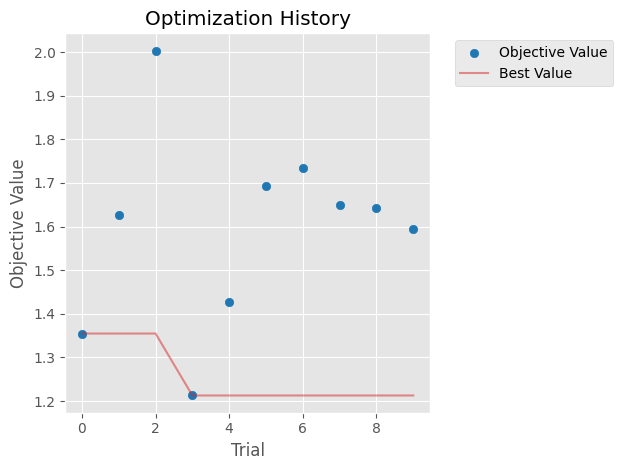

In [13]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from gluonts.dataset.split import OffsetSplitter
import copy
from datetime import datetime, timedelta

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    
    # Fixed parameters
    n_splits = 3  # Number of cross-validation folds - 1 means no cross-validation
    
    # Create time-based splits for cross-validation
    # We'll use the last n_splits chunks of the training data
    total_length = len(data)
    cv_length = total_length // (n_splits + 1)  # Reserve 1 part for final validation
    
    # Calculate start dates for each fold
    start_idx = total_length - (n_splits * cv_length)
    fold_start_indices = [start_idx + i * cv_length for i in range(n_splits)]
    
    # Create date-based splits
    fold_start_dates = [data.index[idx] for idx in fold_start_indices]
    
    # Store metrics for each fold
    fold_metrics = []
    
    # Perform cross-validation
    for fold, start_date in enumerate(fold_start_dates):
        print(f"\nTraining fold {fold+1}/{n_splits}")
        
        # Create train/val split for this fold
        train_end_date = start_date - timedelta(hours=1)
        val_end_date = start_date + timedelta(hours=cv_length-1)
        
        # Create datasets for this fold
        train_data_fold = data.loc[:train_end_date]
        val_data_fold = data.loc[start_date:val_end_date]
        
        # Convert to GluonTS format
        train_ds_fold = PandasDataset(
            train_data_fold,
            target="Temperature (C)",
            freq="H"
        )
        
        val_ds_fold = PandasDataset(
            val_data_fold,
            target="Temperature (C)",
            freq="H"
        )
        
        # Create the estimator with trial hyperparameters
        estimator_fold = LagLlamaEstimator(
            ckpt_path=ckpt_path,
            prediction_length=prediction_length,
            context_length=context_length,
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            time_feat=estimator_args["time_feat"],
            nonnegative_pred_samples=True,
            aug_prob=0.5,
            lr=lr,
            batch_size=batch_size,
            num_parallel_samples=num_samples,
            trainer_kwargs={"max_epochs": 30, "deterministic": True},
            dropout=0.1
        )
        
        # Train the model
        predictor_fold = estimator_fold.train(
            train_ds_fold, 
            cache_data=True,
            shuffle_buffer_length=1000,
            validation_data=val_ds_fold
        )
        
        # Make predictions
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=val_ds_fold,
            predictor=predictor_fold,
            num_samples=num_samples
        )
        
        forecasts_fold = list(forecast_it)
        tss_fold = list(ts_it)
        
        # Evaluate predictions
        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss_fold), iter(forecasts_fold))
        
        # Store metrics
        fold_metrics.append(agg_metrics["RMSE"])
        
        print(f"Fold {fold+1} RMSE: {agg_metrics['RMSE']:.4f}")
        
        # Clean up to free memory
        del train_ds_fold, val_ds_fold, estimator_fold, predictor_fold
        del forecasts_fold, tss_fold
        import gc
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Calculate average RMSE across folds
    avg_rmse = sum(fold_metrics) / len(fold_metrics)
    print(f"\nTrial completed with parameters: lr={lr}")
    print(f"Average RMSE across {n_splits} folds: {avg_rmse:.4f}")
    
    return avg_rmse  # Return the objective to minimize

# Create and run the Optuna study
study = optuna.create_study(direction="minimize", study_name="lag_llama_cv", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10)  # Adjust n_trials based on your computational resources

# Print the best parameters
print("\nBest trial:")

trial = study.best_trial
print(f"  Value (RMSE): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualize the optimization results
try:
    # Plot optimization history
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title('Optimization History')
    plt.tight_layout()
    plt.show()
   
except Exception as e:
    print(f"Could not generate visualization: {e}")

# Use the best parameters for the final model
best_lr = trial.params["lr"]


In [14]:
# Save the best hyperparameters and study
import json
import os

# Save the best hyperparameters
best_params = {
    "lr": best_lr,
    "context_length": context_length,
    "prediction_length": prediction_length
}

# Create a directory for saving if it doesn't exist
os.makedirs("model_artifacts", exist_ok=True)

# Save hyperparameters as JSON
with open("model_artifacts/best_hyperparameters.json", "w") as f:
    json.dump(best_params, f, indent=4)

# Save the Optuna study
study.trials_dataframe().to_csv("model_artifacts/optuna_trials.csv")

print(f"Best hyperparameters saved to model_artifacts/best_hyperparameters.json")
print(f"Optuna study results saved to model_artifacts/optuna_trials.csv")


Best hyperparameters saved to model_artifacts/best_hyperparameters.json
Optuna study results saved to model_artifacts/optuna_trials.csv


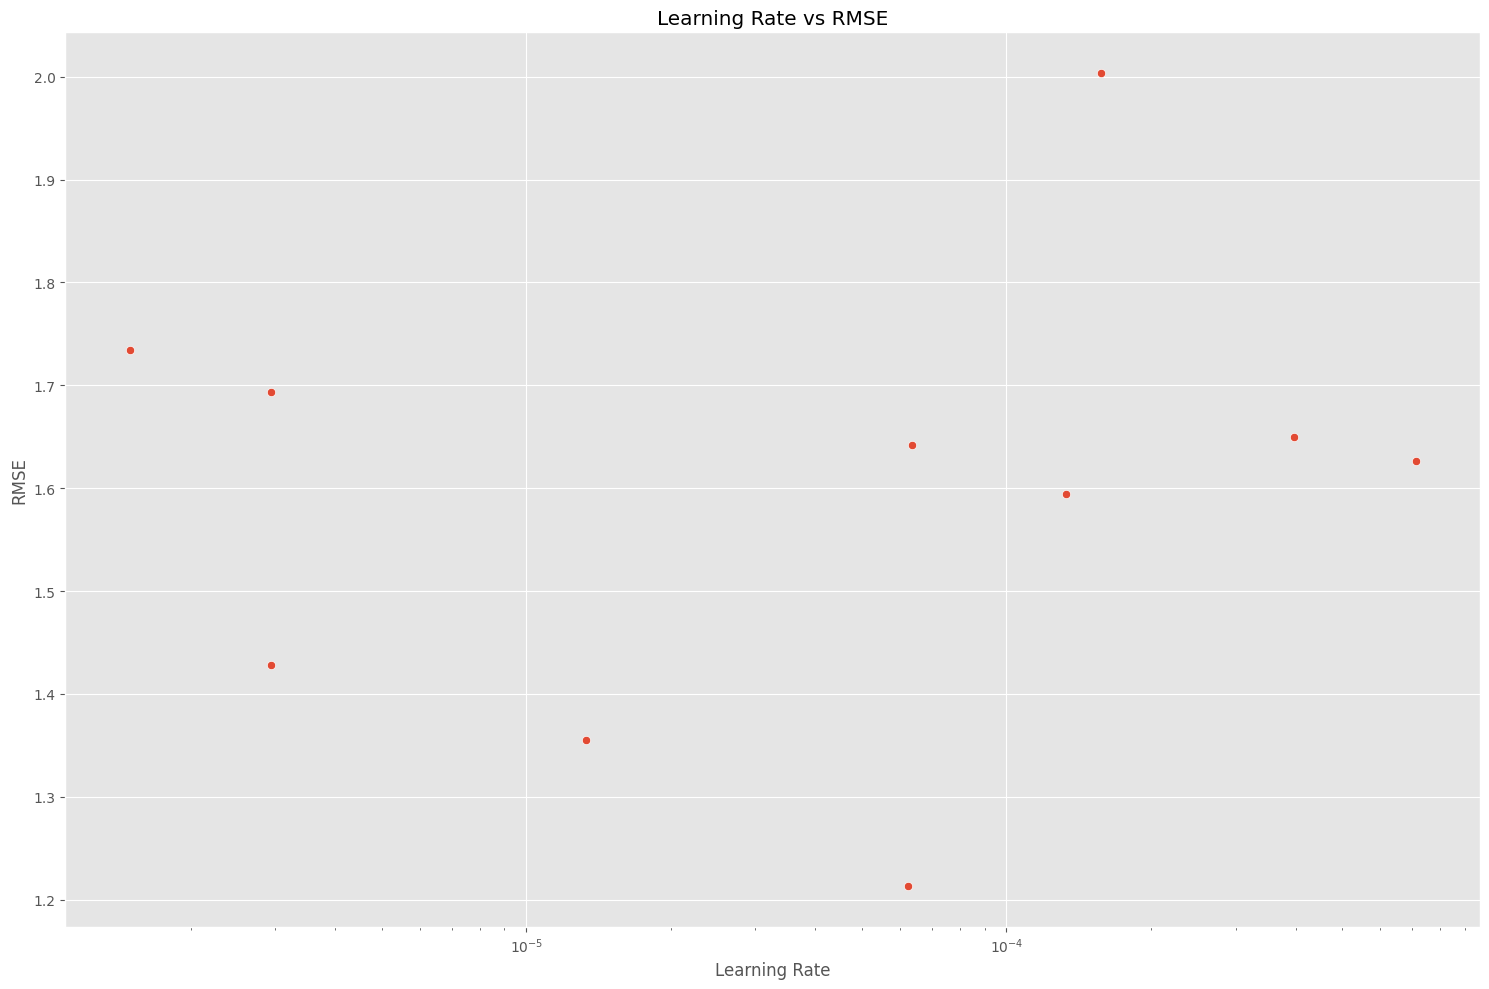

Cross-Validation Summary Statistics:
Number of trials: 10
Best RMSE: 1.2129
Mean RMSE: 1.5939
Std Dev RMSE: 0.2196
Worst RMSE: 2.0035

Hyperparameter Comparison (Baseline vs Optimized):
Learning Rate: 0.0001 -> 6.251373574521755e-05

Improvement over baseline RMSE (1.7285): 29.83%


In [15]:
# Analyze the cross-validation results
import pandas as pd
import seaborn as sns

# Load the study results
study_results = pd.read_csv("model_artifacts/optuna_trials.csv")

# Plot the parameter distributions
plt.figure(figsize=(15, 10))

# Create a 1x2 grid of subplots
plt.subplot(1, 1, 1)
sns.scatterplot(x='params_lr', y='value', data=study_results)
plt.title('Learning Rate vs RMSE')
plt.xscale('log')  # Learning rate is often visualized on log scale
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')




plt.tight_layout()
plt.savefig("model_artifacts/cv_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("Cross-Validation Summary Statistics:")
print(f"Number of trials: {len(study_results)}")
print(f"Best RMSE: {study_results['value'].min():.4f}")
print(f"Mean RMSE: {study_results['value'].mean():.4f}")
print(f"Std Dev RMSE: {study_results['value'].std():.4f}")
print(f"Worst RMSE: {study_results['value'].max():.4f}")

# Compare with baseline (original hyperparameters)
baseline_lr = 1e-4


print("\nHyperparameter Comparison (Baseline vs Optimized):")
print(f"Learning Rate: {baseline_lr} -> {best_lr}")


# Calculate improvement percentage
if 'value' in study_results.columns:
    best_rmse = study_results['value'].min()
    improvement = ((1.7285 - best_rmse) / 1.7285) * 100  # Using RMSE from original model
    print(f"\nImprovement over baseline RMSE (1.7285): {improvement:.2f}%")


In [16]:
# Create the final estimator with the best hyperparameters
final_estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],
    nonnegative_pred_samples=True,
    aug_prob=0.5,
    lr=best_lr,
    batch_size=batch_size,
    num_parallel_samples=num_samples,
    trainer_kwargs={"max_epochs": 30},
    dropout=0.1
)

print(f"Starting model training with best parameters (lr={best_lr})...")
predictor = final_estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000, validation_data=test_ds)
print("Training completed!")


Starting model training with best parameters (lr=6.251373574521755e-05)...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.78653 (best 0.78653), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 0.75254 (best 0.75254), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.57549 (best 0.57549), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 0.49434 (best 0.49434), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' reached 0.48799 (best 0.48799), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=12-step=650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 0.46868 (best 0.46868), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' reached 0.46005 (best 0.46005), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached 0.41142 (best 0.41142), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' reached 0.40366 (best 0.40366), saving model to '/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/BerlinWeatherTimeSeriesAnalysis/lightning_logs/version_30/checkpoints/epoch=25-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Training completed!


## Making Predictions using the best Model

In [17]:
# Make predictions
print("Making predictions...")
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=num_samples
)

forecasts = list(tqdm(forecast_it, total=len(test_ds), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(test_ds), desc="Ground truth"))


Making predictions...


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1 [00:00<?, ?it/s]

## Evaluation of model performance

### Metrics

In [18]:
print("Evaluating predictions...")
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


# Display metrics
print(f"\nEvaluation Metrics on test data:")
print(f"RMSE: {agg_metrics['RMSE']:.4f}")
print(f"MASE: {agg_metrics['MASE']:.4f}")
print(f"MAPE: {agg_metrics['MAPE']:.4f}")
print(f"sMAPE: {agg_metrics['sMAPE']:.4f}")

total_prediction_points = len(forecasts) * len(forecasts[0].index)
mae = agg_metrics['abs_error'] / total_prediction_points
print(f"MAE: {mae:.4f}")

Evaluating predictions...


Running evaluation: 1it [00:02,  2.20s/it]
/storage/courses/dsw/weather_project/BerlinWeatherTimeSeriesAnalysis/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(



Evaluation Metrics on test data:
RMSE: 1.1639
MASE: 0.6480
MAPE: 0.0641
sMAPE: 0.0626
MAE: 1.2926


### Prediction of a single day

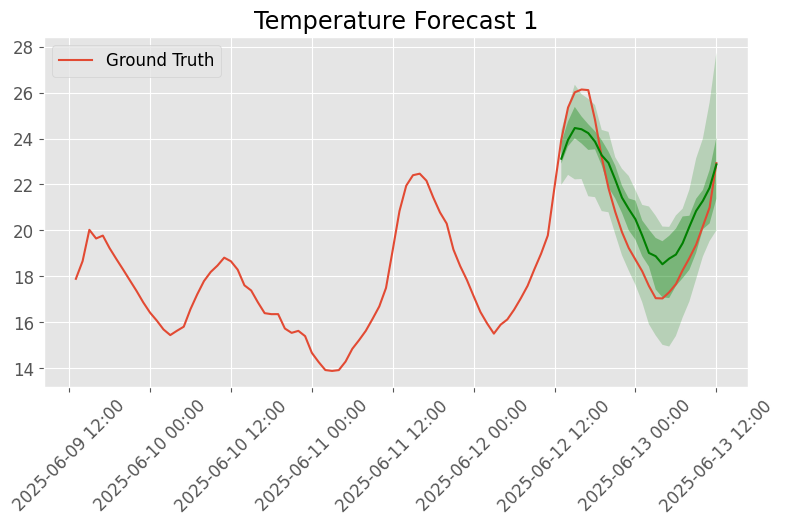

In [19]:
# Visualize predictions
plt.figure(figsize=(20, 10))
date_formater = mdates.DateFormatter('%Y-%m-%d %H:%M')
plt.rcParams.update({'font.size': 12})

# Plot the first few predictions
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
    ax = plt.subplot(2, 2, idx+1)
    
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="Ground Truth")
    forecast.plot(color='g')
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(date_formater)
    plt.title(f"Temperature Forecast {idx+1}")
    plt.legend()

plt.show()

### Prediction for a whole week of known data


Creating individual day plots for 2023-01-08 to 2023-01-14...
Day 1: Using 168 hours of context data
Day 2: Using 168 hours of context data
Day 3: Using 168 hours of context data
Day 4: Using 168 hours of context data
Day 5: Using 168 hours of context data
Day 6: Using 168 hours of context data
Day 7: Using 168 hours of context data


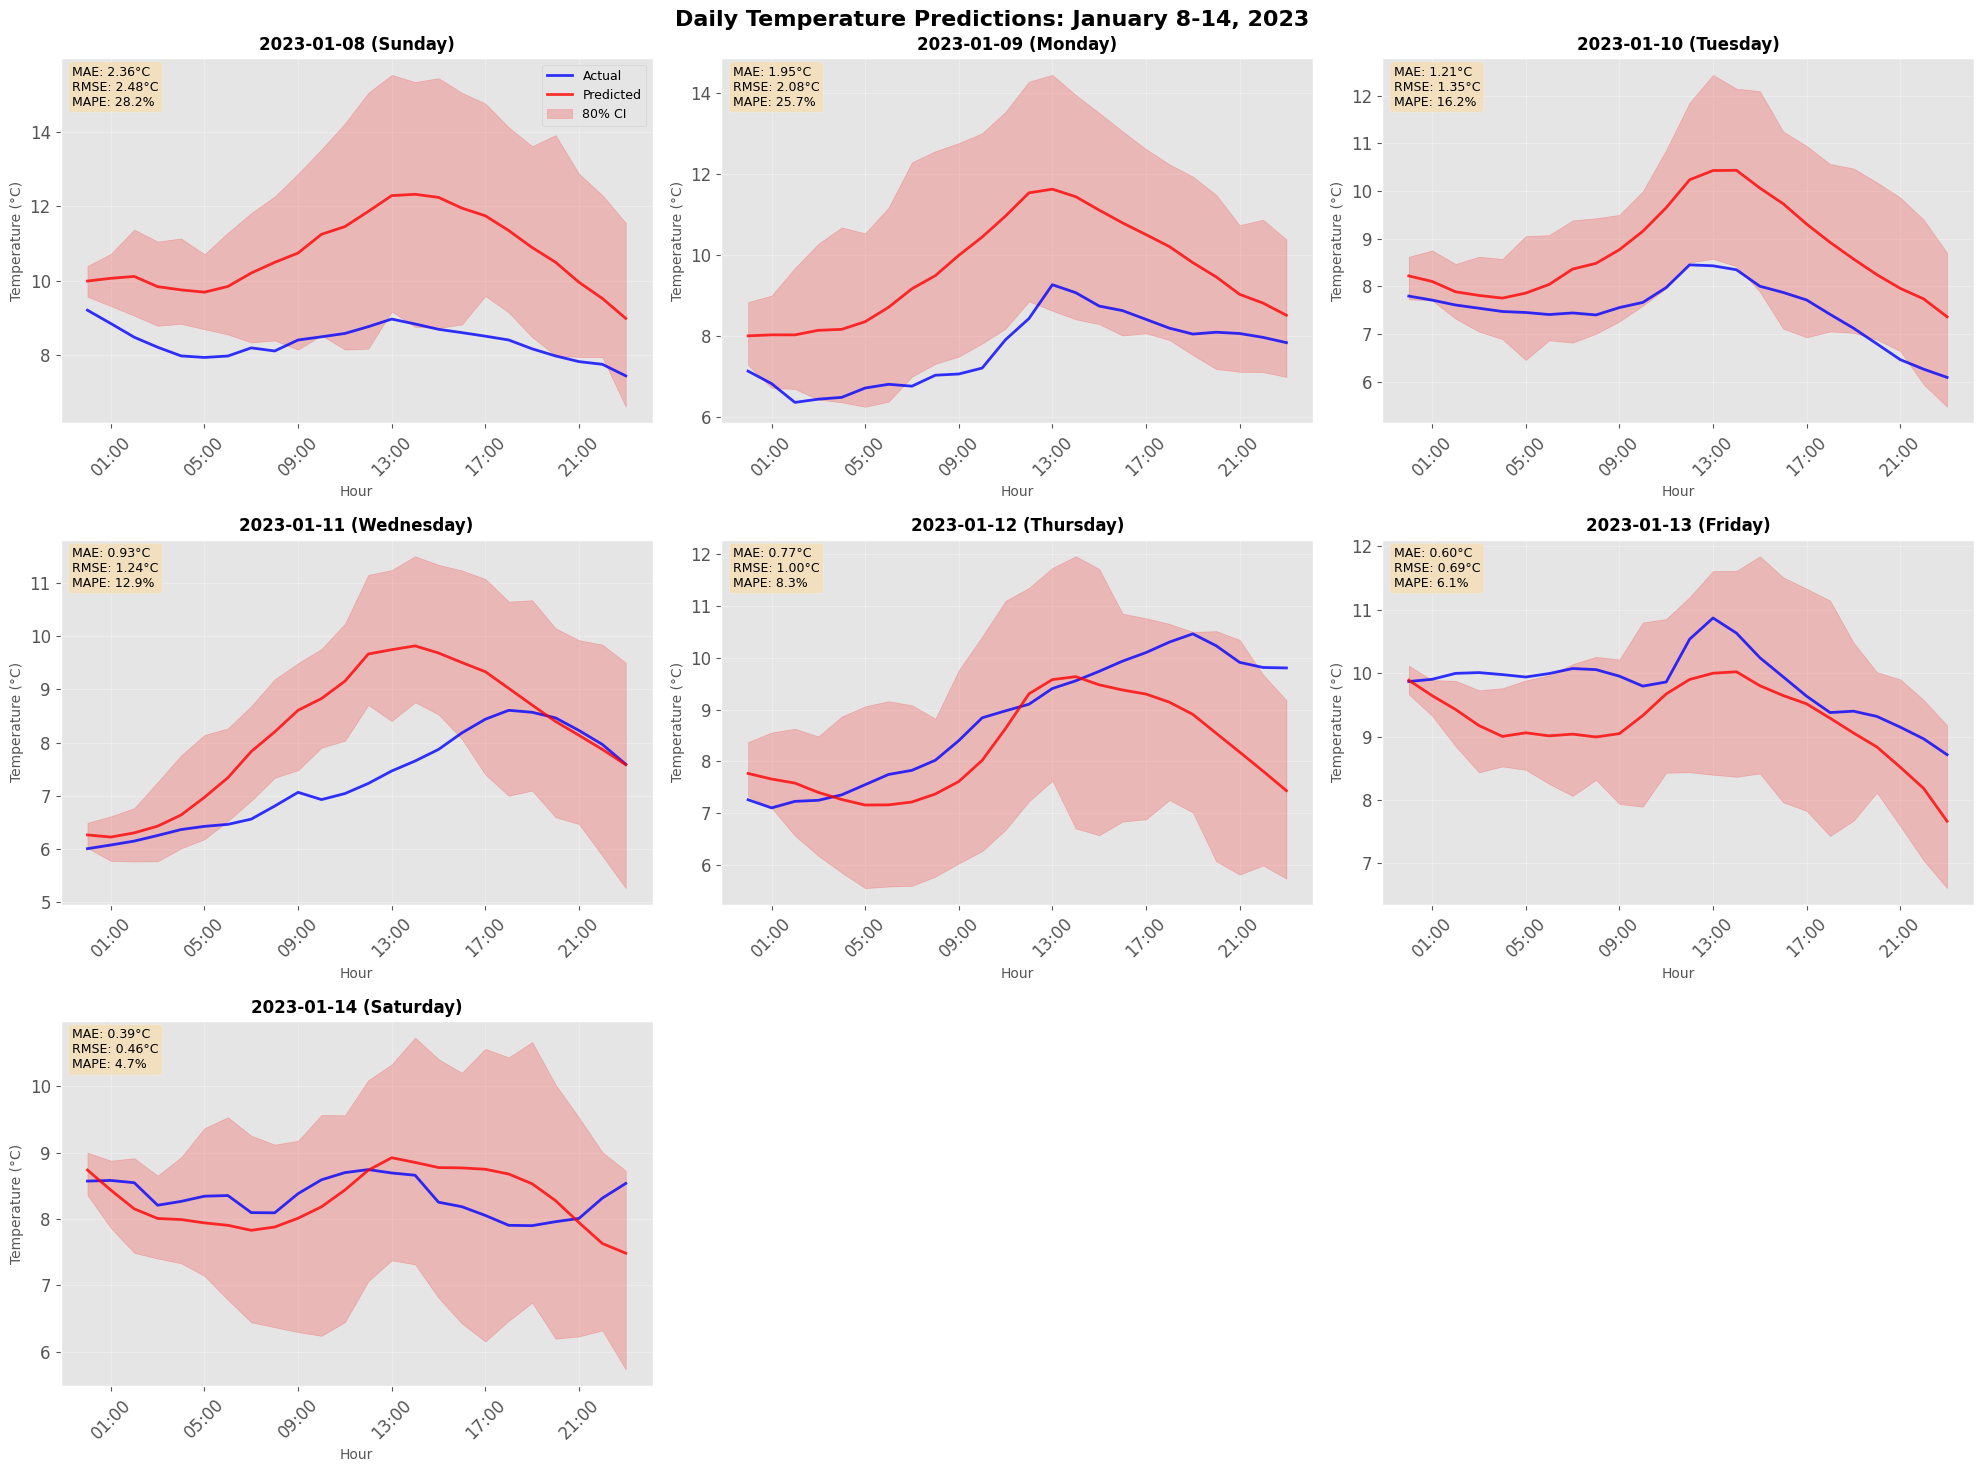

In [20]:
print("\nCreating individual day plots for 2023-01-08 to 2023-01-14...")

start_date = '2023-01-08'
end_date = '2023-01-14'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a 3x3 subplot layout for 7 days (with 2 empty spots)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for day_idx, current_date in enumerate(date_range):
    ax = axes[day_idx]
    
    # Get actual data for this specific day
    day_start = current_date.strftime('%Y-%m-%d')
    day_end = (current_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1)).strftime('%Y-%m-%d %H:%M:%S')
    
    actual_day_data = data[day_start:day_end]['Temperature (C)']
    
    if len(actual_day_data) > 0:
        #Create context data that includes everything up to the prediction day
        context_start = current_date - pd.Timedelta(days=7)   # Use 7 days of context
        context_end = current_date - pd.Timedelta(hours=1)     # End just before the target day
        
        context_data = data[context_start:context_end]
        
        if len(context_data) >= context_length:  # Use the model's context_length
            print(f"Day {day_idx+1}: Using {len(context_data)} hours of context data")
            
        
            # Create a continuous time series that includes context + target period
            # This is what make_evaluation_predictions expects
            full_period_start = context_start
            full_period_end = current_date + pd.Timedelta(hours=23)  # Full target day
            
            full_period_data = data[full_period_start:full_period_end]
            
            if len(full_period_data) > context_length:
                # Create dataset with the full period (context + target)
                full_ds = PandasDataset(
                    full_period_data,
                    target="Temperature (C)",
                    freq="H"
                )
                
                # Use make_evaluation_predictions properly
                forecast_it_day, ts_it_day = make_evaluation_predictions(
                    dataset=full_ds,  # Dataset with context + target
                    predictor=predictor,
                    num_samples=num_samples
                )
                
                forecasts_day = list(forecast_it_day)
                tss_day = list(ts_it_day)
                
                if forecasts_day and tss_day:
                    forecast_day = forecasts_day[0]
                    ts_day = tss_day[0]
                    
                    # DEBUG: Print shapes and values
                    # print(f"Forecast shape: {forecast_day.mean.shape if hasattr(forecast_day, 'mean') else 'No mean attr'}")
                    # print(f"Forecast mean range: {forecast_day.mean.min():.2f} to {forecast_day.mean.max():.2f}" if hasattr(forecast_day, 'mean') else "No mean")
                    
                    # print(f"Actual data range: {actual_day_data.min():.2f} to {actual_day_data.max():.2f}")
                    
                    # Plot actual temperature for the day
                    ax.plot(actual_day_data.index, actual_day_data.values, 'b-', 
                            label='Actual', linewidth=2, alpha=0.8)
                    
                    # Handle forecast values properly
                    if hasattr(forecast_day, 'mean'):
                        forecast_values = forecast_day.mean
                        
                        # Ensure we have the right number of predictions
                        if len(forecast_values) >= len(actual_day_data):
                            # Take only the hours we need for this day
                            forecast_values = forecast_values[:len(actual_day_data)]
                            forecast_time = actual_day_data.index
                        else:
                            # Extend forecast_time to match available predictions
                            forecast_time = actual_day_data.index[:len(forecast_values)]
                        
                        # Plot predicted temperature
                        ax.plot(forecast_time, forecast_values, 'r-', 
                                label='Predicted', linewidth=2, alpha=0.8)
                        
                        # Add confidence interval
                        if hasattr(forecast_day, 'quantile'):
                            lower_bound = forecast_day.quantile(0.1)[:len(forecast_values)]
                            upper_bound = forecast_day.quantile(0.9)[:len(forecast_values)]
                            ax.fill_between(forecast_time, lower_bound, upper_bound, 
                                            alpha=0.2, color='red', 
                                            label='80% CI' if day_idx == 0 else "")
                           
                        # Calculate metrics for this day
                        if len(forecast_values) >= len(actual_day_data):
                            # Use only matching length for metrics
                            pred_for_metrics = forecast_values[:len(actual_day_data)]
                            day_rmse = np.sqrt(np.mean((actual_day_data.values - pred_for_metrics) ** 2))
                            day_mae = np.mean(np.abs(actual_day_data.values - pred_for_metrics))
                            day_mape = np.mean(np.abs((actual_day_data.values - pred_for_metrics) / (actual_day_data.values + 1e-8))) * 100
                            
                            # Add text box with metrics
                            textstr = f'MAE: {day_mae:.2f}°C\nRMSE: {day_rmse:.2f}°C\nMAPE: {day_mape:.1f}%'
                            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
                            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
                                    verticalalignment='top', bbox=props)
                        
    
    # Formatting
    ax.set_title(f'{current_date.strftime("%Y-%m-%d")} ({current_date.strftime("%A")})', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour', fontsize=10)
    ax.set_ylabel('Temperature (°C)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Every 4 hours
    
    # Add legend only to the first subplot
    if day_idx == 0:
        ax.legend(fontsize=9)

# Hide unused subplots
for i in range(len(date_range), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Daily Temperature Predictions: January 8-14, 2023', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Prediction for 6 days new, unknown data

Test Day 1 (2025-01-01): Using 168 hours of context data
Test Day 2 (2025-01-02): Using 168 hours of context data
Test Day 3 (2025-01-03): Using 168 hours of context data
Test Day 4 (2025-01-04): Using 168 hours of context data
Test Day 5 (2025-01-05): Using 168 hours of context data
Test Day 6 (2025-01-06): Using 168 hours of context data


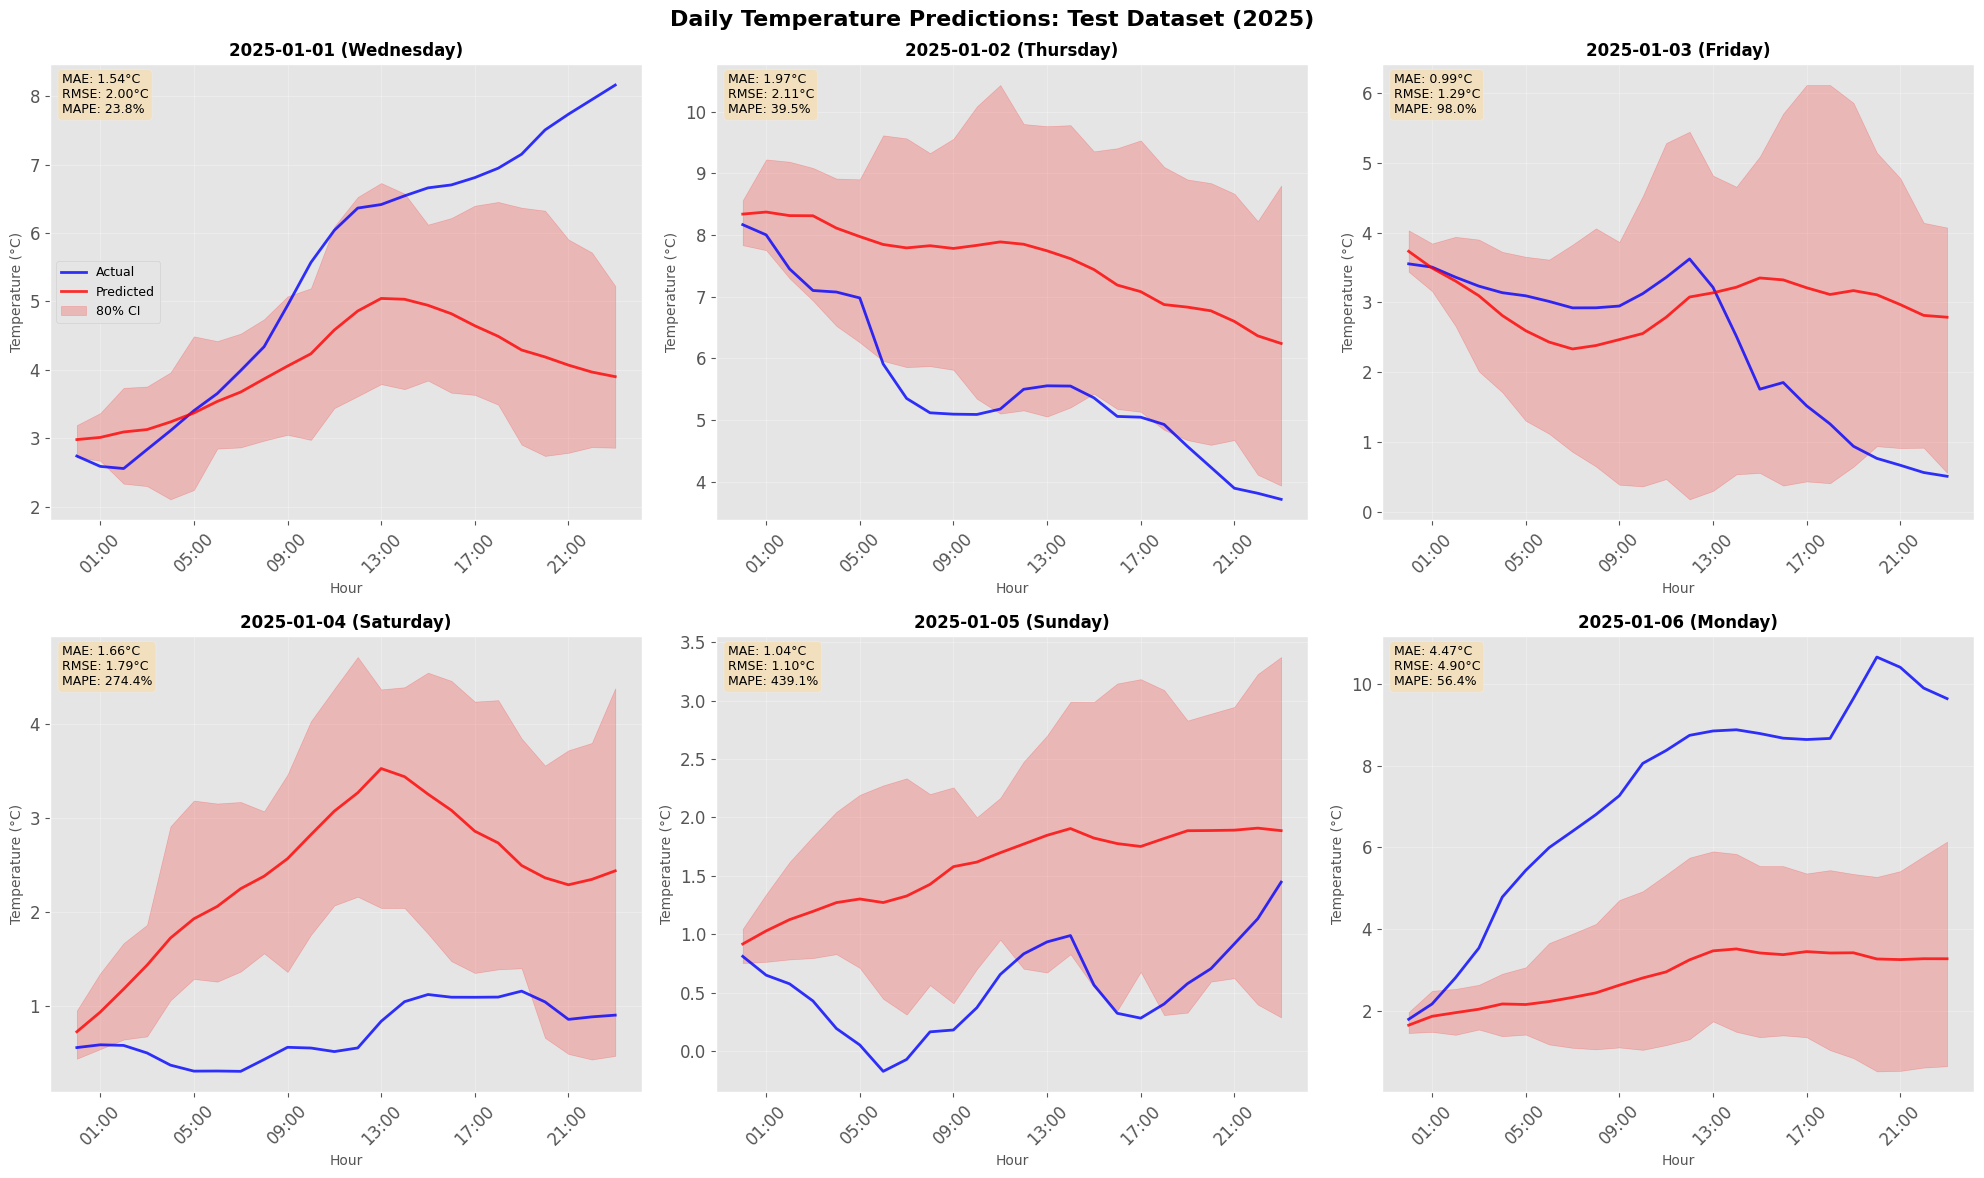

In [21]:

# Get the first 6 days from test dataset
test_start_date = test_data.index[0].date()
test_date_range = pd.date_range(start=test_start_date, periods=6, freq='D')

# Create a 2x3 subplot layout for 6 days
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for day_idx, current_date in enumerate(test_date_range):
    ax = axes[day_idx]
    
    # Get actual data for this specific day from test dataset
    day_start = current_date.strftime('%Y-%m-%d')
    day_end = (current_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1)).strftime('%Y-%m-%d %H:%M:%S')
    
    actual_day_data = test_data["Temperature (C)"][day_start:day_end]
    
    if len(actual_day_data) > 0:
        # CORRECTED: Use rolling context approach
        context_start = current_date - pd.Timedelta(days=7)
        context_end = current_date - pd.Timedelta(hours=1)
        
        # Combine training data context + previous test days as context
        context_parts = []
        
        # 1. Get training data context (as much as available)
        training_context = data[context_start:context_end]
        if len(training_context) > 0:
            context_parts.append(training_context.to_frame(name="Temperature (C)") if isinstance(training_context, pd.Series) else training_context[["Temperature (C)"]])
        
        # 2. If we need more context, use previous test days
        if len(training_context) < context_length:
            # Calculate how much test data we need to include as context
            needed_hours = context_length - len(training_context)
            
            # Get the test data from start up to (but not including) current day
            test_context_end = current_date - pd.Timedelta(hours=1)
            test_context_start = max(test_data.index[0], test_context_end - pd.Timedelta(hours=needed_hours-1))
            
            test_context = test_data["Temperature (C)"][test_context_start:test_context_end]
            if len(test_context) > 0:
                context_parts.append(test_context.to_frame(name="Temperature (C)") if isinstance(test_context, pd.Series) else test_context[["Temperature (C)"]])
        
        # Combine all context parts
        if context_parts:
            combined_context = pd.concat(context_parts)
            # Remove duplicates and sort by index
            combined_context = combined_context[~combined_context.index.duplicated()].sort_index()
        else:
            combined_context = pd.DataFrame()
        
        print(f"Test Day {day_idx+1} ({current_date.strftime('%Y-%m-%d')}): Using {len(combined_context)} hours of context data")
        
        if len(combined_context) >= min(context_length, 24):  # At least 24 hours or context_length
            # Create continuous time series: context + target day
            full_data_parts = [combined_context]
            
            # Add target day
            target_df = actual_day_data.to_frame(name="Temperature (C)") if isinstance(actual_day_data, pd.Series) else actual_day_data[["Temperature (C)"]]
            full_data_parts.append(target_df)
            
            # Combine all data
            full_data = pd.concat(full_data_parts)
            full_data = full_data[~full_data.index.duplicated()].sort_index()
            
            if len(full_data) > len(combined_context):  
                # Create dataset
                full_ds = PandasDataset(
                    full_data,
                    target="Temperature (C)",
                    freq="H"
                )
                
                # Make predictions
                forecast_it_day, ts_it_day = make_evaluation_predictions(
                    dataset=full_ds,
                    predictor=predictor,
                    num_samples=num_samples
                )
                
                forecasts_day = list(forecast_it_day)
                tss_day = list(ts_it_day)
                
                if forecasts_day and tss_day:
                    forecast_day = forecasts_day[0]
                    ts_day = tss_day[0]
                    
                    # DEBUG: Print shapes and values
                    # print(f"  Forecast shape: {forecast_day.mean.shape if hasattr(forecast_day, 'mean') else 'No mean attr'}")
                    # if hasattr(forecast_day, 'mean'):
                    #     print(f"  Forecast range: {forecast_day.mean.min():.2f} to {forecast_day.mean.max():.2f}")
                    # print(f"  Actual range: {actual_day_data.min():.2f} to {actual_day_data.max():.2f}")
                    
                    # Plot actual temperature
                    ax.plot(actual_day_data.index, actual_day_data.values, 'b-', 
                            label='Actual', linewidth=2, alpha=0.8)
                    
                    # Plot predictions
                    if hasattr(forecast_day, 'mean'):
                        forecast_values = forecast_day.mean
                        
                        # Match lengths
                        if len(forecast_values) >= len(actual_day_data):
                            forecast_values = forecast_values[:len(actual_day_data)]
                            forecast_time = actual_day_data.index
                        else:
                            forecast_time = actual_day_data.index[:len(forecast_values)]
                        
                        # Plot predicted temperature
                        ax.plot(forecast_time, forecast_values, 'r-', 
                                label='Predicted', linewidth=2, alpha=0.8)
                        
                        # Add confidence interval
                        if hasattr(forecast_day, 'quantile'):
                            lower_bound = forecast_day.quantile(0.1)[:len(forecast_values)]
                            upper_bound = forecast_day.quantile(0.9)[:len(forecast_values)]
                            ax.fill_between(forecast_time, lower_bound, upper_bound, 
                                            alpha=0.2, color='red', 
                                            label='80% CI' if day_idx == 0 else "")
                           
                        
                        # Calculate metrics
                        if len(forecast_values) >= len(actual_day_data):
                            pred_for_metrics = forecast_values[:len(actual_day_data)]
                            day_rmse = np.sqrt(np.mean((actual_day_data.values - pred_for_metrics) ** 2))
                            day_mae = np.mean(np.abs(actual_day_data.values - pred_for_metrics))
                            day_mape = np.mean(np.abs((actual_day_data.values - pred_for_metrics) / (actual_day_data.values + 1e-8))) * 100
                            
                            textstr = f'MAE: {day_mae:.2f}°C\nRMSE: {day_rmse:.2f}°C\nMAPE: {day_mape:.1f}%'
                            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
                            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
                                    verticalalignment='top', bbox=props)
                        
    
    # Formatting
    ax.set_title(f'{current_date.strftime("%Y-%m-%d")} ({current_date.strftime("%A")})', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour', fontsize=10)
    ax.set_ylabel('Temperature (°C)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    
    # Add legend only to the first subplot
    if day_idx == 0:
        ax.legend(fontsize=9)

plt.suptitle('Daily Temperature Predictions: Test Dataset (2025)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()